In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from enum import Enum
status_columns = ["base_hp", "base_attack", "base_defense", "base_special_attack", "base_special_defense", "base_speed"]

# Extração 
Essa função faz o download de todos os pokemons (dado um range que respeite a National Dex) a partir da [pokeapi](https://pokeapi.co/)

In [2]:
def fetch_pokedex_from_pokeapi(init, end):
    data = []
    for i in range(init, end + 1):
        # Capturando informações sobre o Pokemon
        res = requests.get(f"https://pokeapi.co/api/v2/pokemon-species/{i}").json()
        color = res["color"]["name"]
        is_legendary = res["is_legendary"]
        is_mythical = res["is_mythical"]
        name = res["name"]
        shape = res["shape"]["name"]
        image_url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{i}.png"
        # testando o modelo com pokemons lendários
        # if is_legendary:
        #     continue

        current_row = {"color": color, "is_legendary": is_legendary, "is_mythical": is_mythical, "name": name,
                       "shape": shape,
                       "image_url": image_url}
        try:
            # Capturando status
            battle_res = requests.get(f"https://pokeapi.co/api/v2/pokemon/{name}").json()
            status_res = battle_res["stats"]
            types = [c_type["type"]["name"] for c_type in battle_res["types"]]
            current_row["type"] = types
            for status in status_res:
                status_name = status['stat']['name'].replace("-", "_")
                status = status['base_stat']
                current_row[f"base_{status_name}"] = status
            data.append(current_row)
        except:
            #TODO: tratar pokemons com varias formas
            print("Pokemon com várias formas")
            print(f"https://pokeapi.co/api/v2/pokemon/{name}")
    df = pd.DataFrame.from_records(data)
    df.to_pickle('./pokemons_dataset.pkl')
    return df

# Gen 6
def fetch_pokedex():
    start, end = 1, 650
    try:
        return pd.read_pickle('./pokemons_dataset.pkl')
    except:
        return fetch_pokedex_from_pokeapi(start, end)

def pokemon_shapes(pokedex_df):
    return pokedex_df["shape"].unique()

# Tipos

Aqui criamos uma matriz de efetividade para todos os tipos de Pokemon.  
Por exemplo, a matriz indexada nas posições [1(fogo)][4(grama)] tem o valor 2. Isso quer dizer que golpes de tipo fogo são super efetivos contra pokemons de tipo grama.

In [3]:
## Create types effectiveness matrix
class Types(Enum):
    Normal = 0
    Fire = 1
    Water = 2
    Electric = 3
    Grass = 4
    Ice = 5
    Fighting = 6
    Poison = 7
    Ground = 8
    Flying = 9
    Psychic = 10
    Bug = 11
    Rock = 12
    Ghost = 13
    Dragon = 14
    Dark = 15
    Steel = 16
    Fairy = 17

damage_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 / 2, 0, 1, 1, 1 / 2, 1],
                          [1, 1/2, 1/2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1/2, 1, 1/2, 1, 2, 1],
                          [1, 2, 1/2, 1, 1/2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1/2, 1, 1, 1],
                          [1, 1, 2, 1/2, 1/2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1/2, 1, 1, 1],
                          [1, 1/2, 2, 1, 1/2, 1, 1, 1/2, 2, 1/2, 1, 1/2, 2, 1, 1/2, 1, 1/2, 1],
                          [1, 1/2, 1/2, 1, 2, 1/2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1/2, 1],
                          [2, 1, 1, 1, 1, 2, 1, 1/2, 1, 1/2, 1/2, 1/2, 2, 0, 1, 2, 2, 1/2],
                          [1, 1, 1, 1, 2, 1, 1, 1/2, 1/2, 1, 1, 1, 1/2, 1/2, 1, 1, 0, 2],
                          [1, 2, 1, 2, 1/2, 1, 1, 2, 1, 0, 1, 1/2, 2, 1, 1, 1, 2, 1],
                          [1, 1, 1, 1/2, 2, 1, 2, 1, 1, 1, 1, 2, 1/2, 1, 1, 1, 1/2, 1],
                          [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1/2, 1, 1, 1, 1, 0, 1/2, 1],
                          [1, 1/2, 1, 1, 2, 1, 1/2, 1/2, 1, 1/2, 2, 1, 1, 1/2, 1, 2, 1/2, 1/2],
                          [1, 2, 1, 1, 1, 2, 1/2, 1, 1/2, 2, 1, 2, 1, 1, 1, 1, 1/2, 1],
                          [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1/2, 1, 1],
                          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1/2, 0],
                          [1, 1, 1, 1, 1, 1, 1/2, 1, 1, 1, 2, 1, 1, 2, 1, 1/2, 1, 1/2],
                          [1, 1/2, 1/2, 1/2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1/2, 2],
                          [1, 1/2, 1, 1, 1, 1, 2, 1/2, 1, 1, 1, 1, 1, 1, 2, 2, 1/2, 1]])

## Classes de batalha

Essa classe descreve todos os tipos de pokemon que irei usar na minha classificação

In [4]:
class BattleRole(Enum):
    Attacker = "Attacker"
    SPAttacker = "SPAttacker"
    Tank = "Tank"
    SPTank = "SPTank"

## Limpando os dados

In [5]:
pokedex_df = fetch_pokedex()

In [6]:
pokedex_df["status_mean"] = pokedex_df[status_columns].mean(axis=1)
pokedex_df = pd.concat([pokedex_df, pd.DataFrame(pokedex_df["type"].to_list(), columns=['type1', 'type2'])], axis=1)

Para melhorar minha analise, irei filtrar apenas 70% dos pokemons com as maiores médias de status (para evitar que pokemons de estágio base sejam considerados).

## Média dos status

<Axes: >

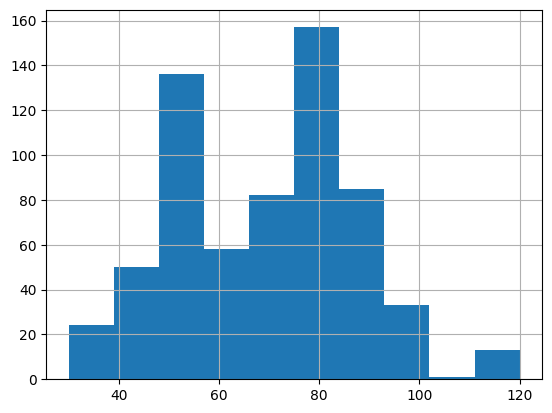

In [7]:
pokedex_df["status_mean"].hist()

Calculando percentis

<Axes: >

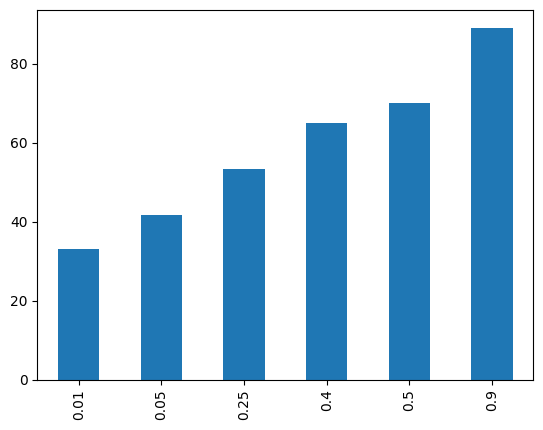

In [8]:
pokedex_df["status_mean"].quantile([.01, 0.05, 0.25, .4, 0.5, .9]).plot.bar()

In [9]:
valor_mediana = pokedex_df["status_mean"].quantile(0.3)

In [10]:
pokedex_df_filtered = pokedex_df[pokedex_df["status_mean"] >= valor_mediana]

In [11]:
pokedex_df_filtered.to_pickle('./pokedex_filtered.pkl')

Text(0, 0.5, 'Quantidade')

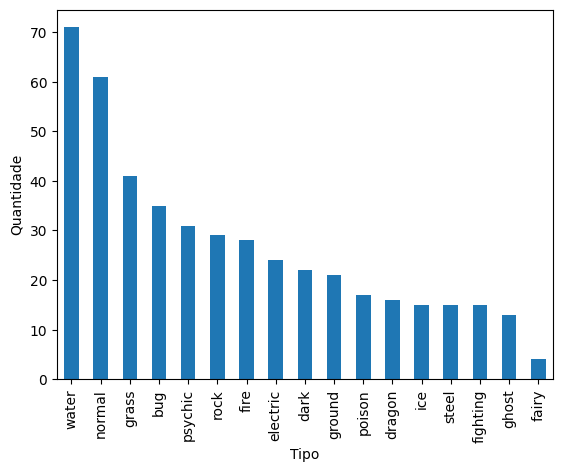

In [12]:
pokedex_df_filtered['type1'].value_counts().plot(kind='bar')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')

Comparando com a distribuição original, podemos ver que não mudou muito.

Text(0, 0.5, 'Quantidade')

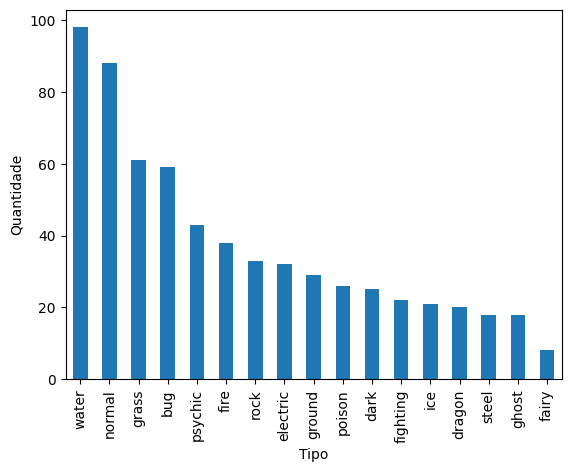

In [13]:
pokedex_df['type1'].value_counts().plot(kind='bar')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')